While the analysis of the Beatles song 'yesterday' gave back results which are in line with our hypothesis (2.1-beta2 is better, flac is better), it is still dependent on the judgement that the song is sad (while the lyrics are sad, the acoustic qualities might not be). Thus, it can be beneficial to find another way of determining this accuracy percentage for different codecs and versions.

To avoid having to specify a 'ground truth' label, we can also look at the binary agreement between mood_sad and mood_happy. Since the combination of these two *roughly* approaches valence (both negative is a valence of 0), we can use the label probabilities from these two classifiers to check if the output is consistent and correct. i.e. we do the following:

## Valid combinations (will be considered 'correct' for any submission)
- (mood_happy, happy) + (mood_sad, not_sad) = positive valence
- (mood_happy, not_happy) + (mood_sad, sad) = negative valence
- (mood_happy, not_happy) + (mood_sad, not_sad) = neutral valence

## Invalid combinations (will be considered 'incorrect' for any submission
- (mood_happy, happy) + (mood_sad, sad) = ?

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Load in the acousticbrainz dataset into the variable 'acousticbrainz' (V3 also include build SHA to make sure that software
# version is the same on a commit basis.
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

def get_accuracy(df):
    incorrect = (df[('mood_happy', 'happy')] > 0.5) & (df[('mood_sad', 'sad')] > 0.5)
    count = incorrect.value_counts()[False]
    return (count, len(incorrect), count/len(incorrect))

def get_mood_counts(df):
    res = {}
    
    res['happy'] = (df[('mood_happy', 'happy')] > 0.5).value_counts()[True]
    res['not_happy'] = (df[('mood_happy', 'not_happy')] > 0.5).value_counts()[True]
    res['sad'] = (df[('mood_sad', 'sad')] > 0.5).value_counts()[True]
    res['not_sad'] = (df[('mood_sad', 'not_sad')] > 0.5).value_counts()[True]
    
    return res

def print_accuracy(groupname, accuracy):
    print(f"{groupname}: {full_dataset[0]}/{full_dataset[1]} = {full_dataset[2] * 100}%")
    

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
accuracies = pd.DataFrame(columns=['Correct', 'Total', 'Percentage', 'Normalized percentage'])

# Run for every group > 10.000
grouped = acousticbrainz.groupby(['bit_rate', 'codec', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low'])
tocheck = grouped.size()[(grouped.size() > 10000)]
display(tocheck)

for groupname, group in grouped:
    if groupname in tocheck:
        acc = get_accuracy(group)
        # Normalize percentage using Rule of succession (assuming binomial distribution)
        accuracies = accuracies.append(pd.Series([acc[0], acc[1], acc[2], (acc[0]+1)/(acc[1]+2)], index=accuracies.columns, name=groupname))

display(accuracies.sort_values(by='Normalized percentage', ascending=False))

bit_rate  codec   essentia_low  essentia_git_sha_low          essentia_build_sha_low                  
0         flac    2.1-beta1     v2.1_beta1-28-g21ef5f4        5c9e65ec81695c916afb4cba055c226bfc528ee6     36800
                                v2.1_beta1-28-g21ef5f4-dirty  ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b     90453
                                v2.1_beta1-6-g5578087         5a55991247aa8bc5301991e5ebe36927b56abb96     17292
                                                              7598a69e7b456135ce4c070efb04a3d0ebb71fdd     10171
                                                              7f154e5731828a63663f0144680ef47bd640f88b     28706
                                v2.1_beta1-7-ge0e83e8-dirty   12879b851c9f4b0d899e1af4e221aa110f283a84     13391
                                                              50a0fbec89d6a9cedea3d45b6611406f7e8c7b1a     14636
                  2.1-beta2     v2.1_beta2                    70f2e5ece6736b2c40cc944ad0e695b16b925413    

,Correct,Total,Percentage,Normalized percentage
"(128000, mp3, 2.1-beta1, v2.1_beta1-28-g21ef5f4-dirty, ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b)",31589.0,31840.0,0.992117,0.992086
"(320000, mp3, 2.1-beta1, v2.1_beta1-28-g21ef5f4-dirty, ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b)",31297.0,31570.0,0.991353,0.991321
"(192000, mp3, 2.1-beta1, v2.1_beta1-28-g21ef5f4-dirty, ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b)",35447.0,35953.0,0.985926,0.985899
"(192000, mp3, 2.1-beta1, v2.1_beta1-34-gf95df8b, 5a811adb4c06fd6d02ca903f7349a26d851abfa8)",10418.0,10582.0,0.984502,0.984410
"(256000, vorbis, 2.1-beta2, v2.1_beta2, 70f2e5ece6736b2c40cc944ad0e695b16b925413)",13236.0,13466.0,0.982920,0.982848
"(160000, mp3, 2.1-beta1, v2.1_beta1-28-g21ef5f4-dirty, ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b)",11574.0,11788.0,0.981846,0.981764
"(192000, mp3, 2.1-beta2, v2.1_beta2, 70f2e5ece6736b2c40cc944ad0e695b16b925413)",23044.0,24057.0,0.957892,0.957854
"(320000, mp3, 2.1-beta2, v2.1_beta2, 70f2e5ece6736b2c40cc944ad0e695b16b925413)",10918.0,11516.0,0.948072,0.947994
"(128000, mp3, 2.1-beta2, v2.1_beta2, 70f2e5ece6736b2c40cc944ad0e695b16b925413)",15990.0,16903.0,0.945986,0.945933
"(0, flac, 2.1-beta1, v2.1_beta1-28-g21ef5f4-dirty, ca57ba49d9b1854bd80e60cf9ccf267278fb7d6b)",85345.0,90453.0,0.943529,0.943519


## Is the 'correctness' assumption correct?
An argument can be made that the correctness assumption is incorrect, since a song might still be both happy and sad (an emotion like melancholy might be applicable here), in this case the four labels have no direct connection to the valence model. Thus, it might be valuable to look at the distribution across these four combinations for the different slices, are they the same accross codec and bitrates? Or are there any notable differences?

In [5]:
cols = ['sad', 'not_sad', 'happy', 'not_happy']
df = pd.DataFrame(columns=cols)

grouped = acousticbrainz.groupby(['bit_rate', 'codec'])
tocheck = grouped.size()[(grouped.size() > 10000)]


for groupname, group in grouped:
    if groupname in tocheck:
        df = df.append(pd.Series(get_mood_counts(group), name=groupname))

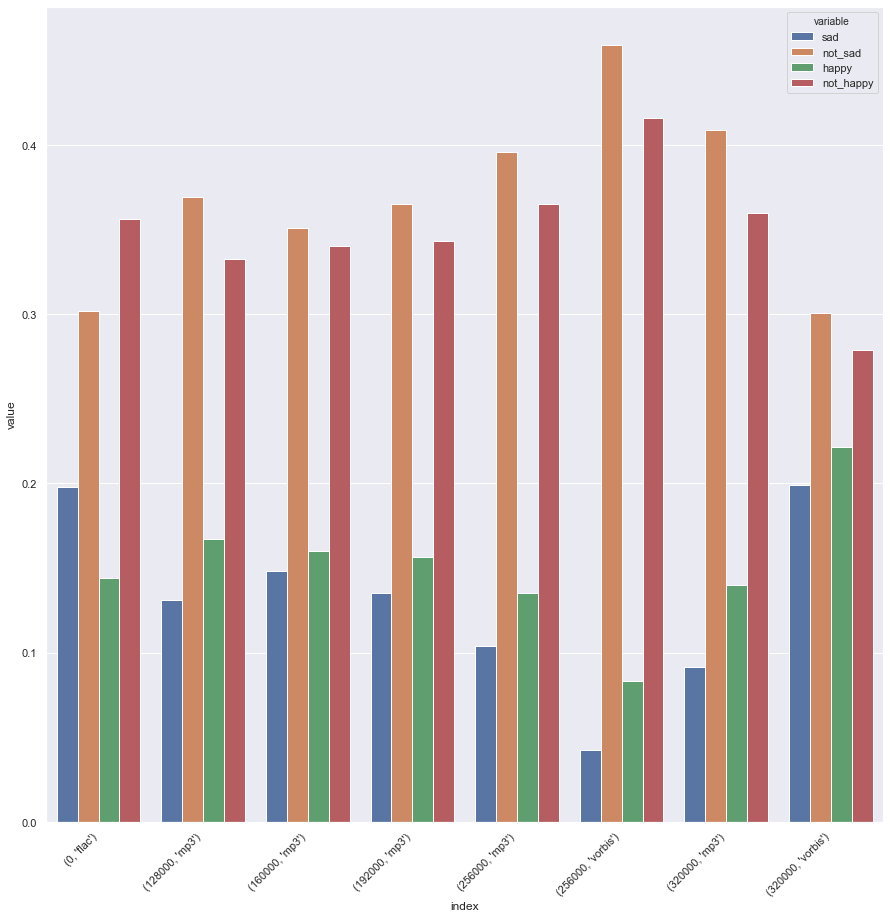

In [6]:
toplot = df.div(df.sum(axis=1), axis=0)
toplot = toplot.reset_index().melt(id_vars=['index'])

plt.figure(figsize=(15,15))
ax = sns.barplot(data=toplot, x='index', y='value', hue='variable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [75]:
grouped = acousticbrainz.groupby(['bit_rate', 'codec'])
tocheck = grouped.size()[(grouped.size() > 10000)]

In [76]:
df = pd.DataFrame()
for groupname, group in grouped:
    if groupname in tocheck:
        df = df.append(group[[('mood_happy', 'happy'), ('mood_sad', 'sad'), 'bit_rate', 'codec']])

In [77]:
toplot = df.melt(['bit_rate', 'codec'])

In [82]:
vals = {}

for row in toplot.iterrows():
    val = row[1]['value']
    idx = f"({row[1]['bit_rate']}, {row[1]['codec']})"
    classifier = row[1]['variable']
    
    if not idx in vals:
        vals[idx] = {}
        
    if not classifier in vals[idx]:
        vals[idx][classifier] = {}    
    
    try:
        vals[idx][row[1]['variable']].append(val)
    except:
        vals[idx][row[1]['variable']] = [val]
        

vals

{'(0, flac)': {('mood_happy', 'happy'): [0.248412579298,
   0.456860184669,
   0.394279062748,
   0.417296826839,
   0.849721848965,
   0.0877693891525,
   0.259612649679,
   0.0908810049295,
   0.0905467122793,
   0.0315249972045,
   0.223628744483,
   0.158477425575,
   0.0656777322292,
   0.0639990270138,
   0.820412397385,
   0.814533531666,
   0.42034637928,
   0.685291409492,
   0.98873591423,
   0.484750628471,
   0.912537872791,
   0.644983887672,
   0.699835836887,
   0.65758395195,
   0.103196002543,
   0.101319588721,
   0.101326160133,
   0.103198260069,
   0.00974810682237,
   0.00974966119975,
   0.00974331144243,
   0.00922050047666,
   0.0094665363431,
   0.926823973656,
   0.815632998943,
   0.65814191103,
   0.147787258029,
   0.0487720556557,
   0.223636701703,
   0.219861477613,
   0.0441541448236,
   0.0441563278437,
   0.020633213222,
   0.7994582057,
   0.871365785599,
   0.534808278084,
   0.998905003071,
   0.99882119894,
   0.998993754387,
   0.560938537121,
 

In [83]:
pd.DataFrame(vals)

,,"(0, flac)","(128000, mp3)","(160000, mp3)","(192000, mp3)","(256000, mp3)","(256000, vorbis)","(320000, mp3)","(320000, vorbis)"
mood_happy,happy,"[0.248412579298, 0.456860184669, 0.39427906274...","[0.32813963294, 0.294220089912, 0.064635314047...","[0.907971024513, 0.816071510315, 0.21592397987...","[0.050010535866, 0.337121576071, 0.99999988079...","[0.355087667704, 0.350272268057, 0.65233677625...","[0.271806329489, 0.00517865875736, 0.005733232...","[0.0393528528512, 0.241447553039, 0.6088016033...","[0.741160690784, 0.00963204726577, 0.009612673..."
mood_sad,sad,"[0.955284893513, 0.0660809725523, 0.0649976730...","[0.428891330957, 0.0717779844999, 0.0829067528...","[0.046803176403, 0.0423133075237, 0.0641030073...","[0.22890368104, 0.193881377578, 0.352291256189...","[0.27684789896, 0.282415509224, 0.329872637987...","[0.0767600759864, 0.369301319122, 0.2907447814...","[0.5, 0.297249495983, 0.149803414941, 0.733513...","[0.278985142708, 0.382642269135, 0.38264837861..."


In [103]:
toplot2 = pd.DataFrame(vals)
cols = list(toplot2.columns)

for row in toplot2.iterrows():
    rowindex = row[0]
    for i in range(0, len(cols)):
        col = row[1][i]
        toplot2.at[rowindex, cols[i]] = np.array(col).mean()

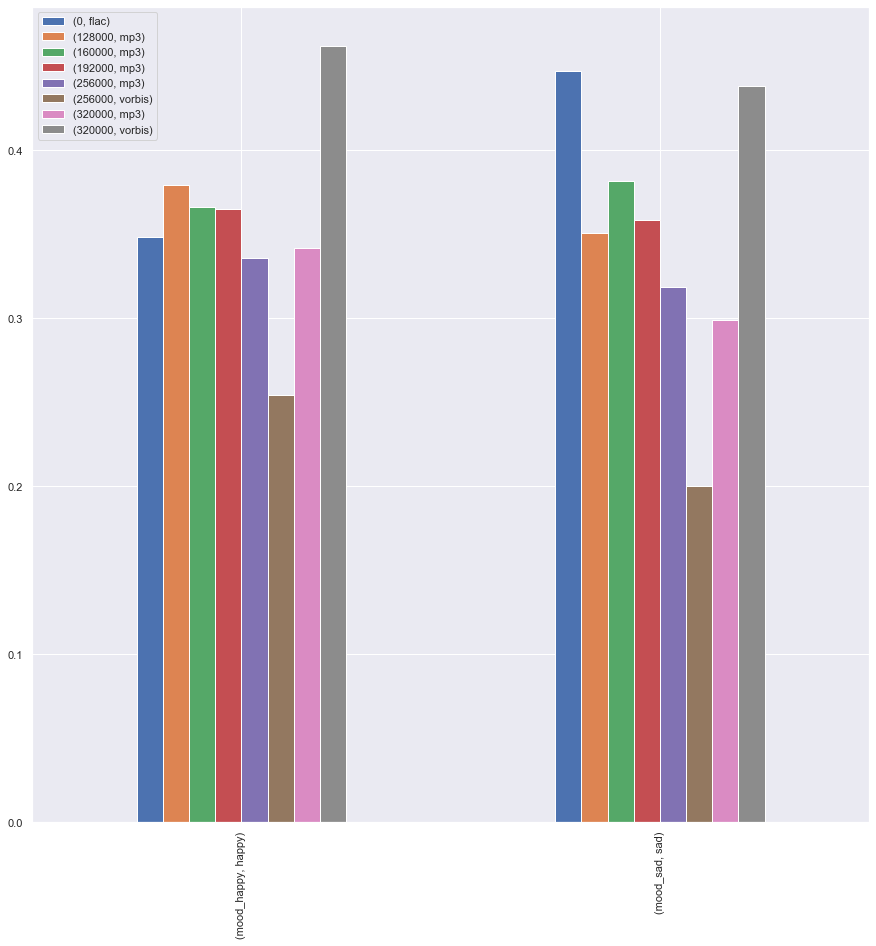

In [105]:
toplot2.plot(kind='bar')